# 1.Data 

### Loading the data

In [1]:
import numpy as np
from datetime import datetime as dt
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import copy
import seaborn as sns

In [2]:
with open ('sx-stackoverflow-a2q.txt') as dataset_a2q:
    a2q=dataset_a2q.readlines()

with open ('sx-stackoverflow-c2a.txt') as dataset_c2a:
    c2a= dataset_c2a.readlines()
    
with open ('sx-stackoverflow-c2q.txt') as dataset_c2q:
    c2q= dataset_c2q.readlines()

### Preprocessing

Note that we're changing the values of the read data instead of creating new variables to store the corrected version, in order to save space.

In [3]:
n=10000 
for i in range(0,0+n):
    a2q[i]=a2q[i].split()
    a2q[i][0]=int(a2q[i][0])
    a2q[i][1]=int(a2q[i][1])
    a2q[i][2]=dt.utcfromtimestamp(int(a2q[i][2])).strftime('%Y-%m-%d')
    
for i in range(0,n):
    c2a[i]=c2a[i].split()
    c2a[i][0]=int(c2a[i][0])
    c2a[i][1]=int(c2a[i][1])
    c2a[i][2]=dt.utcfromtimestamp(int(c2a[i][2])).strftime('%Y-%m-%d')
    
for i in range(0,n):
    c2q[i]=c2q[i].split()
    c2q[i][0]=int(c2q[i][0])
    c2q[i][1]=int(c2q[i][1])
    c2q[i][2]=dt.utcfromtimestamp(int(c2q[i][2])).strftime('%Y-%m-%d')

### Remove answer from user to his own question, i.e. remove loops from corresponding graph

In [4]:
a2q_n=a2q[0:n]
c2a_n=c2a[0:n]
c2q_n=c2q[0:n]

In [5]:
w=0
while w<len(a2q_n):
    if a2q_n[w][0]==a2q_n[w][1]:
        del a2q_n[w]
    else:
        w+=1
naq=len(a2q_n)

In [6]:
x=0
while x<len(c2a_n):
    if c2a_n[x][0]==c2a_n[x][1]:
        del c2a_n[x]
    else:
        x+=1
nca=len(c2a_n)

In [7]:
y=0
while y<len(c2q_n):
    if c2q_n[y][0]==c2q_n[y][1]:
        del c2q_n[y]
    else:
        y+=1
ncq=len(c2q_n)

### To create the graphs, we'll use a nested dictionary

In [8]:
def dateInRange(date, initTime, endTime): #return true if the given date its in the range [initTime, endTime], return false otherwise
    if(initTime == '-' or endTime == '-'):
        return True
    if initTime <= date <= endTime:
        return True
    else:
        return False
    
def createGraph(initTime, endTime, data):
    graph = {}
    for x in range(len(data)):
        if dateInRange(data[x][2], initTime, endTime):
            if data[x][0] in graph: #we already have the node of that user in the graph
                if data[x][1] in graph[data[x][0]]: #we already have one interaction of user data[x][0] with user data[x][1], so we add 1 to the number of interactions
                    graph[data[x][0]][data[x][1]]['weight'] += 1
                else:
                    graph[data[x][0]][data[x][1]] = {'weight': 1} #we don't have an interacion between that 2 users, so we initialize the interaction with a 1 (because till the moment we only have 1 interaction).
            else: #we don't have the node of the user in the graph
                graph[data[x][0]] = {data[x][1] : {'weight': 1}}
    return graph

In [9]:
dict_a2q_n = createGraph('-', '-', a2q_n)
dict_c2a_n = createGraph('-', '-', c2a_n)
dict_c2q_n = createGraph('-', '-', c2q_n)


In [10]:
def mergeTwoGraphs(g1, g2): #merge g1 and g2 into one graph. g1 and g2 must exist.
    #  print("-----------")
    #  print("g1: ", g1)
    #  print("g2: ", g2)
    #  print("-----------")
    for x in g2:
        #print("x: ", x)
        if x in g1: #if in g1 we have the user x, we have to add all his interactions 1 by 1. If the interaction already exists, we just add 1 to the weight.
            for y in g2[x]:
                #print("y: ", y)
                if y in g1[x]:
                    g1[x][y]['weight'] += g2[x][y]['weight']
                else:
                    g1[x][y] = {'weight': 1}
        else: #if in g1 we don't have the user x, we add all his interactions
            #print(x)
            g1[x] = g2[x]
    return g1
    
def mergeGraphs(graphs): #merge the graphs into one graph. The parameter graphs it's and array of all the graphs to merge [g1, g2, ...]
        mergedGraph = {}
        if len(graphs) > 0:
            mergedGraph = graphs[0]
            for x in graphs[1:]:
                mergedGraph = mergeTwoGraphs(mergedGraph, x)       
        return mergedGraph

# 2. Implementation of the backend

## Functionalities 1 and 2 are defined as methods within a class.

In [ ]:
from itertools import count
import networkx as nx


class Graphs:
    def __init__(self, i):
        # <i> should be used in visualization phase.
        # We call each functionality (method) within the class according to
        # the given <i> by the user.
        self.i = i
        self.get_features_results = []
        self.best_user_results = []
        self.init_graph = 0
        self.nx_graph = 0
        self.nodes_numbers = 0

    # First functionality
    def get_features(self, inp_graph):

        # Checking if the graph is undirected or not by looking for
        # similar edges between pairs of vertices.
        def is_directed():
            for u, neigh in inp_graph.items():
                for n in neigh.items():
                    if n[0] in inp_graph:
                        if n[0] != u and not ([(node, w) for node, w in inp_graph[n[0]].items() if (node == u and w == n[1])]):
                            # print("The graph is directed")
                            return 'Yes'
            # print("The graph is undirected.")
            return 'No'

        # Number of users is equal to all the unique values both in keys
        # and values of the given graph in the format of a dictionary.
        def num_of_users():
            _users = []
            for k, v in inp_graph.items():
                _users.append(k)
                for i in [*v]:
                    _users.append(i)
            return len(set(_users))

        # Counting all the values of the sub-dictionaries. If the graph is undirected
        # then we divide the result by two.
        def num_ans():
            _counter = 0
            for i in inp_graph.values():
                _counter += len(i)
            if self.get_features_results[0] == 0:
                return _counter/2
            else:
                return _counter

        # Number of edges / number of vertices
        def avg_links():
            return self.get_features_results[2]/self.get_features_results[1]

        # Two different scenarios based on whether the graph is directed
        # or not
        def density_degree():
            if self.get_features_results[0] == 1:
                _density = self.get_features_results[2] / (self.get_features_results[1]*(self.get_features_results[1] - 1))
            else:
                _density = 2 * self.get_features_results[2] / (self.get_features_results[1] * (self.get_features_results[1] - 1))
            return _density

        # if density < 0.5 then it is sparse; otherwise it is considered dense.
        def sparsity():
            if self.get_features_results[4] <= 0.5:
                # print("Sparse!")
                return 'Sparse'
            else:
                # print("Dense!")
                return 'Dense'

        self.get_features_results.append(is_directed())
        self.get_features_results.append(num_of_users())
        self.get_features_results.append(num_ans())
        self.get_features_results.append(avg_links())
        self.get_features_results.append(density_degree())
        self.get_features_results.append(sparsity())

        return self.get_features_results

    # Making the graph dictionary symmetrical
    def construct_nx_graph(self):

        for k, v in self.init_graph.items():
            for ind in v:
                v[ind] = {'weight': v[ind]}
        temp_graph = nx.DiGraph(self.init_graph)
        temp_graph.add_nodes_from(self.init_graph.keys())

        return temp_graph

    # Now we have the base for functionality #2
    def best_user(self, t_node, init_time, end_time):

        self.init_graph = mergeGraphs([createGraph(init_time, end_time, a2q_n),
                                       createGraph(init_time, end_time, c2a_n),
                                       createGraph(init_time, end_time, c2q_n)])

        self.nx_graph = self.construct_nx_graph()
        self.nodes_numbers = self.nx_graph.number_of_nodes()

        def betweeness():

            def shiftDOWN(heap, st, pos):
                temp_item = heap[pos]
                while pos > st:
                    parentpos = (pos - 1) >> 1
                    parent = heap[parentpos]
                    if temp_item < parent:
                        heap[pos] = parent
                        pos = parentpos
                        continue
                    break
                heap[pos] = temp_item

            def shiftUP(heap, pos):
                endpos = len(heap)
                startpos = pos
                newitem = heap[pos]
                # Bubble up the smaller child until hitting a leaf.
                childpos = 2 * pos + 1  # leftmost child position
                while childpos < endpos:
                    # Set childpos to index of smaller child.
                    rightpos = childpos + 1
                    if rightpos < endpos and not heap[childpos] < heap[rightpos]:
                        childpos = rightpos
                    # Move the smaller child up.
                    heap[pos] = heap[childpos]
                    pos = childpos
                    childpos = 2 * pos + 1
                # The leaf at pos is empty now.  Put newitem there, and bubble it up
                # to its final resting place (by sifting its parents down).
                heap[pos] = newitem
                shiftDOWN(heap, startpos, pos)

            def heappush(heap, item):
                heap.append(item)
                shiftDOWN(heap, 0, len(heap) - 1)

            def heappop(heap):
                lastelt = heap.pop()
                if heap:
                    returnitem = heap[0]
                    heap[0] = lastelt
                    shiftUP(heap, 0)
                    return returnitem
                return lastelt

            btwns = dict.fromkeys(self.nx_graph, 0.0)
            # s is the source
            S = []      # The shortest path
            P = {}      # The previous node in the shortest path

            # Initializing the previous path of each node as null
            for v in self.nx_graph:
                P[v] = []
            # Having a pure list of nodes in a dict with value of 0 of each unseen node and 1 for each seen one
            temp_dict = dict.fromkeys(self.nx_graph, 0.0)
            D = {}
            temp_dict[t_node] = 1.0      # Making the source node as seen
            Q = []  # out heap
            seen = {t_node: 0}
            c = count()
            temp_push = heappush
            temp_pop = heappop
            Q.append((0, next(c), t_node, t_node))
            temp_push(Q, (0, next(c), t_node, t_node))
            while Q:
                (distance, _, pred, v) = temp_pop(Q)
                if v in D:
                    continue  # already searched this node.
                temp_dict[v] += temp_dict[pred]  # Counting the number of paths
                S.append(v)
                D[v] = distance
                for w, edges in self.nx_graph[v].items():
                    vw_dist = distance + edges.get('weight', 1)
                    if w not in D and (w not in seen or vw_dist < seen[w]):
                        seen[w] = vw_dist
                        temp_push(Q, (vw_dist, next(c), v, w))
                        temp_dict[w] = 0.0
                        P[w] = [v]
                    elif vw_dist == seen[w]:  # handle equal paths
                        temp_dict[w] += temp_dict[v]
                        P[w].append(v)

            # Then we accumulate the results of the Dijkstra without having any target (sink) node
            d_t = dict.fromkeys(S, 0)
            while S:
                t1 = S.pop()
                _coeffs = (1 + d_t[t1]) / temp_dict[t1]
                for node in P[t1]:
                    d_t[node] += temp_dict[node] * _coeffs
                if t1 != t_node:
                    btwns[t1] += d_t[t1]

            return btwns

        def PageRank():

            # Page rank has been defined for directed graphs and even if the graph is undirected
            # we make each egde in the
            iterations = 100
            directed_graph = self.nx_graph
            if not directed_graph.is_directed():
                directed_graph = directed_graph.to_directed()

            RSF = nx.stochastic_graph(directed_graph, weight='weight')
            starting_point = dict.fromkeys(RSF, 1./ self.nodes_numbers)
            pv = dict.fromkeys(RSF, 1./self.nodes_numbers)
            dw = pv
            dn = [node for node in RSF if RSF.out_degree(node, weight='weight') == 0]

            for _ in range(iterations):
                last_point = starting_point
                starting_point = dict.fromkeys(last_point.keys(), 0)
                dang = 0.5 * sum(last_point[node] for node in dn)
                for i in starting_point:
                    for j in RSF[i]:
                        starting_point[j] += 0.5 * last_point[i] * RSF[i][j]['weight']
                    starting_point[i] += dang * dw[i] + 0.5 * pv[i]
                _error = sum([abs(starting_point[n] - last_point[n]) for n in starting_point])
                tolerance = 1.0e-6
                if _error < self.nodes_numbers * tolerance:
                    return starting_point


        def ClossnesscEntrality():

            S = []
            P = {}
            for v in self.nx_graph:
                P[v] = []
            temp_dict = dict.fromkeys(self.nx_graph, 0.0)  # sigma[v]=0 for v in G
            D = {}
            temp_dict[t_node] = 1.0
            D[t_node] = 0
            Q = [t_node]
            while Q:  # use BFS to find shortest paths
                v = Q.pop(0)
                S.append(v)
                Dv = D[v]
                sigmav = temp_dict[v]
                for w in self.nx_graph[v]:
                    if w not in D:
                        Q.append(w)
                        D[w] = Dv + 1
                    if D[w] == Dv + 1:  # this is a shortest path, count paths
                        temp_dict[w] += sigmav
                        P[w].append(v)
            Clos_Cent = 0
            sp = D
            totsp = sum(sp.values())
            if totsp > 0 and len(self.nx_graph)>1:
                Clos_Cent = (len(sp) -1) / totsp
            else:
                Clos_Cent = 0

            return Clos_Cent

        def DegreeCentrality():

            # nodes connected to the desired node
            connections = len(MYGRAPH[t_node])
            DC = connections / self.nodes_numbers
            return DC

        self.best_user_results.append(betweeness())
        self.best_user_results.append(PageRank())
        self.best_user_results.append(DegreeCentrality())
        self.best_user_results.append(ClossnesscEntrality())


# Testing with both directed and undirected (dense) graphs
# uncomment for directed graph
# my_dict = {'A': {'B': 2, 'C': 3}, 'B': {'A': 4, 'C': 5, 'D':10}}
# uncomment for undirected graph
# my_dict = {'A': {'B': 2, 'C': 3}, 'B': {'A': 2, 'C': 5}, 'C':{'A':3, 'B':5}}

# i = 1 indicates functionality 1
# graph_features = Graphs(1)
# report = graph_features.get_features(my_dict)
# print(report)
g = Graphs(1)
print(g.best_user('A'))


## FUNCTIONALITY 3

### Dijkstra algorithm to get single source shortest path

In [11]:
def dijkstra(g,start,end):
    s=start
    route=[]
    #remaining_seq= [x for x in seq if (x not in route)]
    dist={}
    finalized={}
    for i in g.keys(): #initialize visited as false for all nodes
        dist[i]= np.inf
        finalized[i]=False
    dist[s]=0
    finalized[s]=True
    route.append(s)
    #remaining_seq.remove(s)
    while s != end:
        adj=[]
        for u in list(g[s].keys())  : #for every neighbor of s
            if u in g:
                if finalized[u]==False: #if it's not finalized
                    adj.append(u) #add to adjacent nodes which aren't finalized, then update distance
                    x=dist[s]+g[s][u]['weight']
                    if dist[u]>x:
                        dist[u]=x
        for k in adj:
            if k==end: # if the end node is adjacent
                route.append(k) #add end to route, then end
                return (route)
        if len(adj)==0: #if we reach a leaf
            route.remove(s) #remove it
            s=route[-1] #return to previous node
            route.remove(s) #remove duplicate of previous node
        else:
            m=[k for k, v in dist.items() if v ==min(dist[a] for a in adj)] #get node/nodes that has/have minimum distance
            m=[k for k in m if (finalized[k]==False and k in adj)] #remove the ones not adjacent or finalized
            s=m[-1] #take last one
        finalized[s]=True
        route.append(s)
        adj=[]
    return(route)

### Function to check if 2 nodes are in the same component

In [12]:
def in_same_component(x,y,g): # to check if nodes x and y are in the same connected component in graph g
    neighbors=[x]
    for i in neighbors:
        if i in g:
            for u in list(g[i].keys()):
                if u not in neighbors:
                    if u in g:
                        neighbors.append(u)
    if y in neighbors:
        return True
    return False
    

def shortest_ordered_route(initTime, endTime, seq, start,end): #take p_1 (or p_j) and p_n as input
    g=nx.Graph(createGraph(initTime, endTime, merged_Graphs))
    route=[]
    route.extend(dijkstra(g,start,seq[0]))
    for i in range(0,len(seq)-1):
        route.extend(dijkstra(g,seq[i],seq[i+1])[1:])
    route.extend(dijkstra(g,seq[-1],end)[1:])
    return(route)

### Create the graph for functionality 3

In [13]:
def graph_fun3(a2q,c2a,c2q,initTime,endTime):
    a2q_fun3=[i for i in a2q if initTime <= i[2] <=endTime]
    c2a_fun3=[i for i in c2a if initTime <= i[2] <=endTime]
    c2q_fun3=[i for i in c2q if initTime <= i[2] <=endTime]
    g=mergeGraphs([createGraph('-', '-', a2q_fun3),createGraph('-', '-', c2a_fun3),createGraph('-', '-', c2q_fun3)])
    return g

### Create single function that calls all previous ones

In [14]:
def shortest_ordered_route(initTime,endTime, seq, start, end):
    g=graph_fun3(a2q,c2a,c2q,initTime,endTime)
    if in_same_component(start,end,g)==True:
        route=[]
        route.extend(dijkstra(g,start,seq[0]))
        for i in range(0,len(seq)-1):
            route.extend(dijkstra(g,seq[i],seq[i+1])[1:])
        route.extend(dijkstra(g,seq[-1],end)[1:])
        return(route)
    return(print("Not possible"))

### Visualization 3 - Visualize the Shortest Ordered Route

In [15]:
def visual3(shortest_path,seq):
    v = nx.DiGraph()
    for i in range(0,len(shortest_path)-1):
        v.add_edge(shortest_path[i],shortest_path[i+1])
    plt.rcParams['figure.figsize'] = [15,10]
    val_map = {shortest_path[0]: 1, #mark start to visualize in a different color
               shortest_path[-1]: 0.0} #mark end to visualize in a different color
    for i in range(1, len(shortest_path)-2):
        if shortest_path[i] in seq: #mark sequence of nodes given as input to visualize in a different color
            val_map[shortest_path[i]]=0.75
    values = [val_map.get(node, 0.25) for node in v.nodes()]
    nx.draw(v, nx.spring_layout(v), cmap=plt.get_cmap('viridis'), node_color=values, with_labels=True,font_color='black')
    #nx.draw_networkx_nodes(v, nx.spring_layout(v))
    plt.show()

## FUNCTIONALITY 4

For solving the problem we are going to use the Ford Fulkerson algorithm. That's because if we get the max flow that can go trough the graph from a user to the other, we know that the min cut sum of weight will be the same. A quick reasoning of why that works is:

    As the max flow it's limited by the links with less capacity, removing them will also mean removing the links that weight less.

Basically, once computed Ford Fulkerson, we have to use the last residual graph created by the algorithm. We will separate the nodes in two sets, the ones that can be reached by the first user, and the ones that can't be reached. If in the original graph there is any link between a node of the first set to a node of the second set, that link its part of the cut, and must be removed.
    
In more detail, what we do is:

<ol>
  <li>Creating the graph using the interval of time</li>
  <li>As we are working with a directed graph, we check if the at least one of the users can reach the other</li>
  <li>If user1 can reach user2, we compute the algorithm mentioned above.</li>
  <li>We do the same than in the last step, if we get a better result, we use that, if not, we use the previous.</li>
</ol>

In [ ]:
def DFS(s, t, visitedNodes, path, g):
    visitedNodes.add(s)
    if s == t: #we are in the node objective
        return path + '.' + str(s)
    if(s in g):#first we check if the node it's in the graph, if not we stop
        for w in g[s]:
            if g[s][w]['weight'] != 0: #we don't use the links with weight 0 because they have no more space to increase the flow
                if w not in visitedNodes:
                    p = DFS(w, t, visitedNodes, path + '.' + str(s), g) #we call recursively the function DFS adding the current node to the path
                    if p: 
                        return p
    return ""

#function that given a path, returns the minimum weigth of the links on it
def minWeigth(path, g):
    minW = float("Inf")
    for x in range(len(path)-1):
        n1 = path[x]
        n2 = path[x+1]
        w = g[n1][n2]['weight']
        minW = min(w, minW)
    return minW

def updateGraph(min_weight, path, g): #we update the graph, and we add the links backwards if they don't exists.
    graph = g
    for x in range(len(path)-1):
        n1 = path[x]
        n2 = path[x+1]
        graph[n1][n2]['weight'] -= min_weight
        
        if n1 not in graph[n2]:
            graph[n2][n1] = {'weight': min_weight}
        else:
            graph[n2][n1]['weight'] += min_weight
    return graph
    
    
#implementation of the Ford Fulkerson algorithm
def fordFulkerson(s, t , graph):
    flow = 0
    path = DFS(s, t, set(), "", graph)
    path = path.split('.')
    if(len(path) > 0 and path[0] == ''):
        path = path[1:]
    path = list(map(int,path))
    count = 0
    while len(path) > 0: #if we find a path we keep going
        count = count + 1
        min_weight = minWeigth(path, graph) #we obtain the minimum weight in the path, that will be the bottleneck. In other words, the maximum fow that we can increase in that path
        flow = flow + min_weight #we add that flow to the total
        graph = updateGraph(min_weight, path, graph) #we update the graph adding the new flow
        path = DFS(s, t, set(), "", graph) #we check if we can find another path
        path = path.split('.')
        if(path[0] == ''):
            path = path[1:]
        path = list(map(int,path))
    return flow, graph

In [ ]:
def functionality4(initTime, endTime, user1, user2):
    
    graph_a2q_n = createGraph(initTime, endTime, a2q_n)
    graph_c2a_n = createGraph(initTime, endTime, c2a_n)
    graph_c2q_n = createGraph(initTime, endTime, c2q_n)
    
    merged_Graphs_func4 = mergeGraphs([graph_a2q_n,graph_c2a_n,graph_c2q_n])
    
    minFlow = float('inf')
    linksCut = []
    user1to2 = True

    #As we are working with a directed graph, we check if from user 1 we can reach user 2 and vice versa. So if we cant find a path
    #that connect users in both directions, we have finished with the objective of disconnect the users.
    if (DFS(user1, user2, set(), "", graph) == "") and (DFS(user2, user1, set(), "", graph) == ""): 
        print("The two users are not connected.")
    else:
        if (DFS(user1, user2, set(), "", graph) != ""):
            maxF, residualGraph = fordFulkerson(user1, user2, copy.deepcopy(graph))
            reachableNodes = []
            nonReachableNodes = []
            for x in graph.keys():
                if x != user1:
                    if DFS(user1, x, set(), "", residualGraph) == "":
                        nonReachableNodes.append(x)
                    else:
                        reachableNodes.append(x)
            #cutWeight = 0
            links = []
            
            '''
            for x in reachableNodes:#if we have a link from a reachable node to a non reachable node, that link it's part of the min cut.
                for y in graph[x].keys():
                    if y in nonReachableNodes:
                        cutWeight += graph[x][y]['weight']
                        links.append((x,y))
            '''
            minFlow = maxF
            linksCut = links


        if (DFS(user2, user1, set(), "", graph) != ""):
            maxF, residualGraph = fordFulkerson(user2, user1, copy.deepcopy(graph))
            reachableNodes = []
            nonReachableNodes = []
            for x in graph.keys():
                if x != user1:
                    if DFS(user2, x, set(), "", residualGraph) == "":
                        nonReachableNodes.append(x)
                    else:
                        reachableNodes.append(x)

            #cutWeight = 0
            links = []
            '''
            for x in reachableNodes:#if we have a link from a reachable node to a non reachable node, that link it's part of the min cut.
                for y in graph[x].keys():
                    if y in nonReachableNodes:
                        cutWeight += graph[x][y]['weight']
                        links.append((x,y))
            '''
            if maxF < minFlow:
                minFlow = maxF
                linksCut = links
                user1to2 = False

        if(user1to2):
            print("The minimum number of links to disconnect user " + str(user1) + " from user " + str(user2) + " is: " + str(len(linksCut)) + '.')

        else:
            print("The minimum number of links to disconnect user " + str(user2) + " from user " + str(user1) + " is: " + str(len(linksCut)) + '.')

        #print("That links are:")
        #for x in linksCut:
        #    print("    " + str(x[0]) + "->" + str(x[1]))
        print("The total weight of that links is " + str(minFlow))

# 3. Implementation of the frontend

### Visualization 1 - Visualize the overall features of the graph

In [16]:
def visual1_table(graph):
    g=Graphs(1)
    f1=g.get_features(graph)
    df = pd.DataFrame([f1],
                  index=pd.Index(['Graph']),
                  columns=['Directed','Number of users','Number of answers/comments',
                           'Average number of links per user','Density degree of the graph','Sparse/Dense'])
    style=df.style.format()
    cell_hover = {  # for row hover use <tr> instead of <td>
        'selector': 'td:hover',
        'props': [('background-color', '#1DC690')]
    }
    headers = {
        'selector': 'th:not(.index_name)',
        'props': 'background-color: #000C66; color: white'
    }
    lines1={
        'selector': 'th', 'props': 'border-left: 1px solid white'
    }
    lines2={
        'selector': 'td', 'props': 'border-left: 1px solid #000066'
    }
    
    return style.set_table_styles([cell_hover,headers,lines1,lines2],axis=0).set_properties(**{'text-align':'center','padding':'6px'})


In [17]:
def visual1_distr(G):
    degrees = [G.degree(n) for n in G.nodes()]
    sns.distplot(degrees, color='#000C66')
    plt.title('Graph density distribution', fontsize=18)
    plt.show()

# FRONTEND

In [18]:
def go_to_functionality():
    value= int(input("Select a functionality from 1 to 4:\n Functionality 1 - Get the overall features of the graph\n Functionality 2 - Find the best users\n Functionality 3 - Shortest Ordered Route\n Functionality 4 - Disconnecting graphs\n"))
    if value==1:
        graph=int(input("Select the dataset:\n 1 - Answers to questions\n 2 - Comments to questions\n 3 - Comments to answers\n Insert corresponding number:"))
        if graph==1:
            g=dict_a2q_n
        elif graph==2:
            g=dict_c2q_n
        else:
            g=dict_c2a_n
        t=visual1_table(g)
        d=visual1_distr(nx.Graph(dict_a2q_n))
        return t
    if value==3:
        initTime= input("Insert initial time: ")
        endTime= input("Insert end time: ")
        start= int(input("Insert first user you wish to visit:" ))
        end= int(input("Insert last user you wish to visit:" ))
        s= input("Insert sequence of users you wish to visit in order:" ).split()
        seq=list(map(int,s))
        shortest_path=shortest_ordered_route(initTime, endTime, seq,start,end)
        print(shortest_path)
        visual3(shortest_path,seq)
    if value ==4:
        initTime= input("Insert initial time: ")
        endTime= input("Insert end time: ")
        start= int(input("Insert first user:" ))
        end= int(input("Insert second user:" ))
        result=functionality4(initTime, endTime,start,end)
        return result

Select a functionality from 1 to 4:
 Functionality 1 - Get the overall features of the graph
 Functionality 2 - Find the best users
 Functionality 3 - Shortest Ordered Route
 Functionality 4 - Disconnecting graphs
 1
Select the dataset:
 1 - Answers to questions
 2 - Comments to questions
 3 - Comments to answers
 Insert corresponding number: 1


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


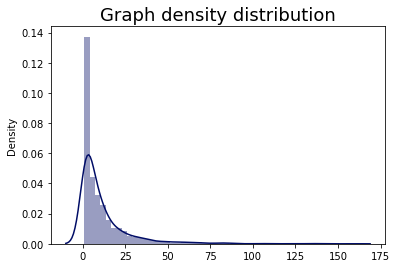

,Directed,Number of users,Number of answers/comments,Average number of links per user,Density degree of the graph,Sparse/Dense
Graph,Yes,1501,8599,5.728847,0.007638,Sparse


In [26]:
go_to_functionality()

Select a functionality from 1 to 4:
 Functionality 1 - Get the overall features of the graph
 Functionality 2 - Find the best users
 Functionality 3 - Shortest Ordered Route
 Functionality 4 - Disconnecting graphs
 3
Insert initial time:  2008-08-01
Insert end time:  2008-09-09
Insert first user you wish to visit: 9
Insert last user you wish to visit: 1982
Insert sequence of users you wish to visit in order: 404 40 1 1339

Select a functionality from 1 to 4:
 Functionality 1 - Get the overall features of the graph
 Functionality 2 - Find the best users
 Functionality 3 - Shortest Ordered Route
 Functionality 4 - Disconnecting graphs
 3
Insert initial time:  2008-08-01
Insert end time:  2008-09-09
Insert first user you wish to visit: 9
Insert last user you wish to visit: 1982
Insert sequence of users you wish to visit in order: 404 40 1 1339


[9, 404, 288, 396, 917, 25, 2018, 80075, 959, 122, 277, 1776, 1813, 1795, 1632, 1368, 1556, 2374, 2213, 184, 2134, 2354, 1120, 61, 1693, 1534, 357, 2141, 770, 2257, 381, 527, 572, 398, 311, 432, 1, 233, 1154, 990, 1554, 383, 40, 1948, 2361, 26, 437, 1384652, 92, 58, 59, 149, 1666, 1951, 572, 322, 1556, 2134, 1632, 1190, 1, 2134, 1632, 453046, 2018, 269, 184, 1337, 1975, 285, 1542, 1384652, 91, 1588, 1178, 993, 369, 637, 763, 1368, 1556, 2374, 2213, 580, 111, 493, 940, 1448, 1175, 322, 1795, 396, 122, 380, 2385, 2614, 1414, 357, 572, 2016, 2555, 2469, 578, 852, 432, 381, 1782, 31505, 377, 1269, 1083, 51, 67, 797, 4926, 1310, 1946, 1549, 92, 1554, 718, 805, 1097, 1874, 83, 49, 1703, 1006, 2191, 486, 1339, 571, 1117, 1220, 519, 889, 1888, 1463, 940, 1448, 116, 117, 1556, 2374, 1116, 1185, 493, 680, 1588, 1178, 372, 565, 2134, 1632, 1384652, 2077, 1693, 2754, 392, 486, 122, 1982]


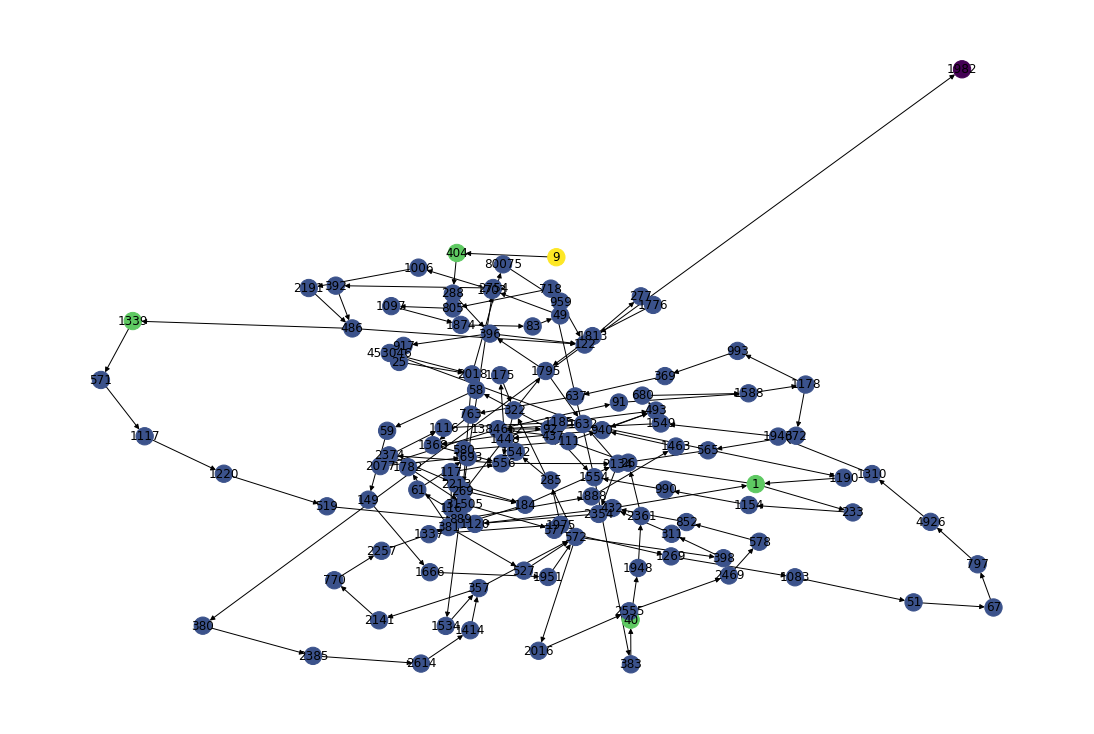

In [19]:
go_to_functionality()